# 2DMD dataset
### Download via attachments [below](https://rolos.com/open/2d-materials-point-defects/#physics)
### View online
1. [Combined dataset](https://my.rolos.com/public/dataframes/866def6e441b4ecfa7e1dbc8bfb22217) 
2. [BP spin high concentration](https://my.rolos.com/public/dataframes/b1f0637c986b40d096c6406ace8c917f)
3. [hBN spin high concentration](https://my.rolos.com/public/dataframes/eebb51ad2031432399bc72537cd5f259)
4. [GaSe spin high concentration](https://my.rolos.com/public/dataframes/4ab4576b7b5b461b9d0225e4640da4c9)
5. [InSe spin high concentration](https://my.rolos.com/public/dataframes/18ba96ae862d44dcac9354d8cbfa5499)
6. [MoS2 high concentration](https://my.rolos.com/public/dataframes/a605211efed04eb9b2320bee76b33112)
7. [MoS2 low concentration](https://my.rolos.com/public/dataframes/f4533115c9be495189d189ce4cecaf57)
8. [WSe2 high concentration](https://my.rolos.com/public/dataframes/1f6f083debb840a882f7cc438c519c15)
9. [WSe2 low concentration](https://my.rolos.com/public/dataframes/4163ecf04ecc453f945dc939e5f71972)

# MoS2 E(distance plots)

In [1]:
from operator import methodcaller
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from ai4mat.data.data import StorageResolver, read_trial

In [2]:
targets = ["formation_energy_per_site"]
results = []
with open("../scripts/ASPIRE-1/MoS2_V2_E.txt", "rt") as definitions_file:
    for line in definitions_file:
        trial, target, n_repeats, _, experiment = line.strip().split()
        for i in range(1, int(n_repeats) + 1):
            these_results = read_trial(experiment, f"stability/{trial}/{i}", True, targets, True)
            if len(these_results) > 0:
                these_results["trial_family"] = trial
                these_results["trial_index"] = i
                results.append(these_results)
results_pd = pd.concat(results, axis=0)
folded_predictions = results_pd.loc[
    ("formation_energy_per_site", "combined"),
    ("trial_family", "trial_index", "predictions")].set_index(
        ["trial_family", "trial_index"]).squeeze()

/tmp/ipykernel_43343/3438766166.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  folded_predictions = results_pd.loc[


In [3]:
predictions_list = []
for (trail_family, trial_index), these_predictions in folded_predictions.items():
    prediction_frame = these_predictions.to_frame()
    prediction_frame["trial_family"] = trail_family
    prediction_frame["trial_index"] = trial_index
    prediction_frame.set_index(["trial_family", "trial_index", prediction_frame.index], inplace=True)
    predictions_list.append(prediction_frame.squeeze())
predictions_pd = pd.concat(predictions_list, axis=0)

In [4]:
structures = pd.read_pickle(StorageResolver()["processed"]/"low_density_defects/MoS2/data.pickle.gz").reindex(
    predictions_pd.index.get_level_values('_id').unique())

In [5]:
distances = structures.defect_representation.apply(methodcaller("get_distance", 0, 1))
distance_order = distances.argsort()

In [6]:
true_energies = structures.formation_energy_per_site

In [7]:
labels = {
    "schnet/25-11-2022_16-52-31/71debf15": "SchNet, tuned",
    "schnet/base": "SchNet, default",
    "catboost/29-11-2022_13-16-01/02e5eda9": "CatBoost, tuned",
    "catboost/base": "CatBoost, default",
    'gemnet/16-11-2022_20-05-04/b5723f85': "GemNet, tuned",
    "gemnet/base": "GemNet, default",
    "megnet_pytorch/25-11-2022_11-38-18/1baefba7": "MegNet (full), tuned",
    'megnet_pytorch/full/base': "MegNet (full), default",
    "megnet_pytorch/sparse/base": "MegNet (sparse), default",
    "megnet_pytorch/sparse/d6b7ce45_no_resample": "MegNet (sparse), tuned",
    "high_to_V2": "Tuned MegNet (sparse),\ntrained on high-density MoS$_2$ only"
}

Plot both the predictions of the models with tuned and default hyperparameters on the same plot. As expected, the tuned model outperform the untuned, with the sparse representation firmly in the lead.

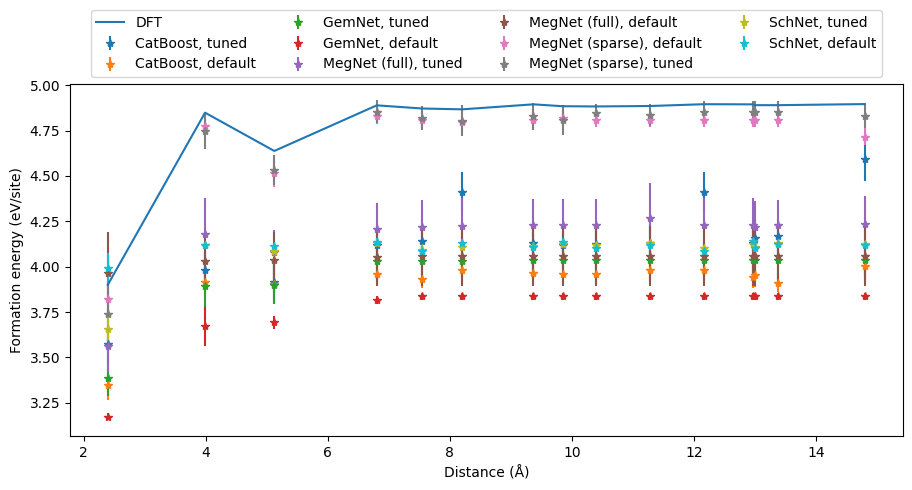

In [8]:
fig, ax = plt.subplots(figsize=(9.5, 5))
for trial_family, family_predictions in predictions_pd.groupby(level="trial_family"):
    prediction_mean = family_predictions.groupby(level="_id").mean()
    prediction_std = family_predictions.groupby(level="_id").std()
    if prediction_std.isna().any():
        ax.scatter(distances, prediction_mean, label=labels[trial_family])
    else:
        ax.errorbar(distances, prediction_mean, yerr=prediction_std, label=labels[trial_family], fmt="*")
ax.plot(distances[distance_order], true_energies[distance_order], label="DFT")
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1), ncol=4)
ax.set_xlabel("Distance (Å)")
ax.set_ylabel("Formation energy (eV/site)")
plt.tight_layout()

In [9]:
font = {
        'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
metadata = {
    "Title": "Energy as a function of ditance between defects in MoS2",
    "Keywords": "2D materials, machine learning, graph neural network, point defects"}

def plot_runs(runs):
        fig, axs = plt.subplot_mosaic([['upper left', 'upper right'],
                               ['middle left', 'middle right'],
                               ['lower', 'lower']],
                               figsize=(10, 10), constrained_layout=True, sharex=False, sharey=True)
        for i, (ax, (trial_family, name)) in enumerate(zip(axs.values(), paper_main.items())):
                family_predictions = predictions_pd.loc[trial_family]
                prediction_mean = family_predictions.groupby(level="_id").mean()
                prediction_std = family_predictions.groupby(level="_id").std()
                if prediction_std.isna().any():
                        predicted = ax.scatter(distances[distance_order], prediction_mean[distance_order], label="Predicted", color="navy", marker='o')
                else:
                        predicted = ax.errorbar(distances[distance_order],
                                                prediction_mean[distance_order],
                                                yerr=prediction_std[distance_order],
                                                color='navy', fmt='o-', mfc='white')
                dft = ax.plot(distances[distance_order], true_energies[distance_order], label="DFT", color="navy", marker='o', linestyle=':',mfc='white')
                ax.grid()
                ax.set_title(name)
                if i == 4:
                        predicted.set_label("Predicted")
                        dft[0].set_label("DFT")
                        ax.legend(loc="lower right")
        fig.supxlabel("Distance between the defects (Å)")
        fig.supylabel("Formation energy (eV/site)")

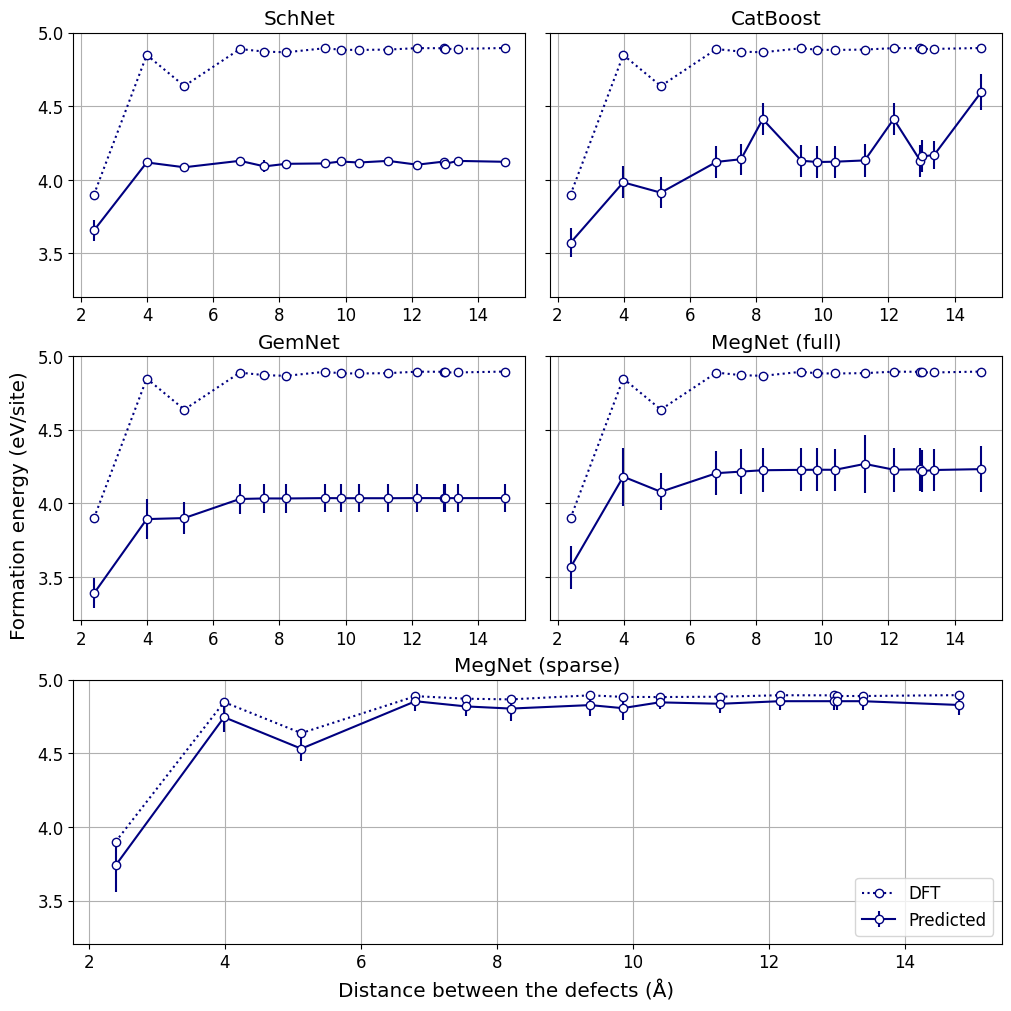

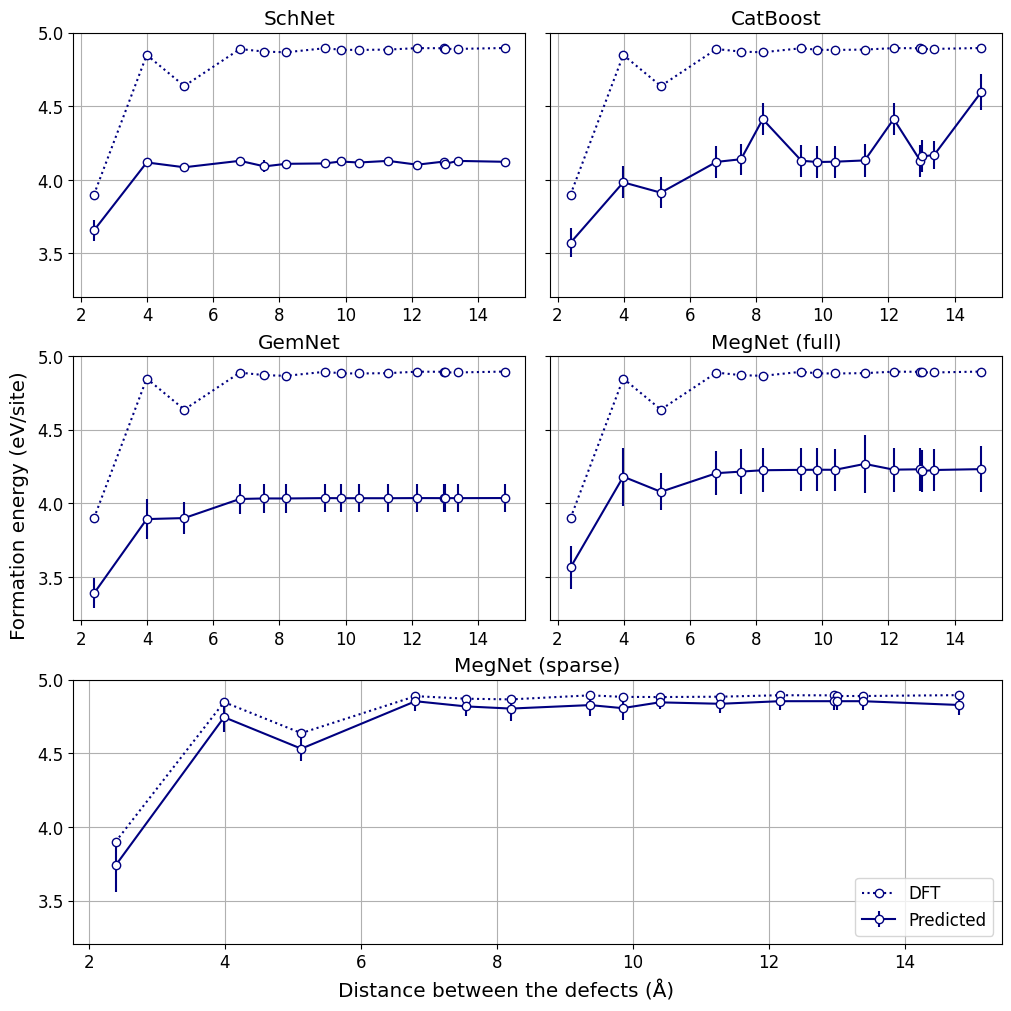

In [10]:
paper_main = {
    "schnet/25-11-2022_16-52-31/71debf15": "SchNet",
    "catboost/29-11-2022_13-16-01/02e5eda9": "CatBoost",
    'gemnet/16-11-2022_20-05-04/b5723f85': "GemNet",
    "megnet_pytorch/25-11-2022_11-38-18/1baefba7": "MegNet (full)",
    "megnet_pytorch/sparse/d6b7ce45_no_resample": "MegNet (sparse)",
}
paper_si = {
    "schnet/base": "SchNet",
    "catboost/base": "CatBoost",
    "gemnet/base": "GemNet",
    'megnet_pytorch/full/base': "MegNet (full)",
    "megnet_pytorch/sparse/base": "MegNet (sparse)",
}
plot_runs(paper_main)
plot_runs(paper_si)

# File format

### `defects.csv.gz`
1. `_id` unique structure identifier
2. `descriptor_id` identifier of the defect type as specified in `descriptors.csv`
3. `defect_id` unused
4. `energy` total potential energy of the system, eV
5. `energy_per_atom` total potential energy of the system divided by the number of atoms, eV
6. `fermi_level` Fermi level, eV
7. `homo` highest occupied molecular orbital (HOMO) energy, eV
8. `lumo` lowest unoccupied molecular orbital (LUMO) energy, eV
9. `normalized_homo` is HOMO value normalised respective to the host valence band maximum (VBM) (see section "DFT computations" in the paper), eV
10. `normalized_homo` is LUMO value normalised respective to the host valence band maximum (VBM) (see section "DFT computations" in the paper), eV
11. `band_gap` is the band gap, LUMO - HOMO, eV
### `initial.tar.gz`
The arcive `initial.tar.gz` contains the unrelaxed structures in the [CIF format](https://doi.org/10.1107%2FS010876739101067X). Names correspond to the unique identifiers `_id` in `defects.csv.gz`. Note that the structures were relaxed prior to computing the properties.
### `descriptors.csv`
1. `_id` unique identifier of the defect type, corresponds to the `descriptor_id` column in `defects.csv`
2. `description` is a short semantic abbreviation of the defect type
3. `base` is the chemical formula of the pristine material
4. `cell` is the supercell size
5. `defects` is a dictionary describing each point defect
### `elements.csv`
Contains chemical potentials (in eV) of the elements, to be used in formation energy computation.
### `initial_structures.csv`
Contains the properties of pristine material.
1. `base` is the chemical formula of the pristine material
2. `cell_size` is the supercell size
3. `energy` total potential energy of the system, eV
4. `fermi` is the Fermi level, eV
## Physics
See the [paper](https://doi.org/10.1038/s41699-023-00369-1)